In [1]:
import os.path as osp
from PIL import Image
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import torchvision
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm.notebook import tqdm
import cv2
import seaborn as sns
from skimage.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix

from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
!unzip /content/drive/MyDrive/itmo/image_generation/dataset.zip -d .

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./dataset/train/80a3e238-61b6-4422-8a21-f740b5f7afbc.jpg  
  inflating: ./dataset/train/80ad0753-12ae-4137-8aab-9eb986f8861a.jpg  
  inflating: ./dataset/train/80b2efb7-85fc-48ee-8d5b-2ea34d8accf6.jpg  
  inflating: ./dataset/train/80b46b08-49c1-48a1-a821-c96845b43fb5.jpg  
  inflating: ./dataset/train/80becd0c-d952-4047-b142-fd71a5abb23e.jpg  
  inflating: ./dataset/train/80bf4307-7774-4135-aad2-bd79da569609.jpg  
  inflating: ./dataset/train/80c385f4-f245-477c-bf88-094ee51162f4.jpg  
  inflating: ./dataset/train/80c8cc53-c349-4707-bc76-ad97f45d7641.jpg  
  inflating: ./dataset/train/80d8587d-1813-4a26-bc45-992888de5de4.jpg  
  inflating: ./dataset/train/80d8aa2c-1a6c-414c-928c-0106fe252691.jpg  
  inflating: ./dataset/train/80e20f46-8ec8-4f05-9646-6a99c85cc82b.jpg  
  inflating: ./dataset/train/80e3d237-ec4d-454c-bd9b-26337b5714fd.jpg  
  inflating: ./dataset/train/80ea41ca-a1a7-436f-bba3-9b86d99d3015.jp

In [5]:
class ProlivDataset(Dataset):
    def __init__(self, images, transforms=None):
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = self.transforms(image)
        return image

In [6]:
train_transforms = T.Compose([
    T.Resize(size=(32, 32)),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.GaussianBlur(5),
    T.RandomPerspective(0.3),
    T.ToTensor(),
    T.Normalize(mean=0, std=1)
])

test_transforms = T.Compose([
    T.Resize(size=(32, 32)),
    T.ToTensor(),
    T.Normalize(mean=0, std=1)
])

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
images_dir = "/content/dataset/train"
images = glob(osp.join(images_dir, "*.jpg"))

split_size = int(len(images)*0.85)
train_images = images[:split_size]
val_images = images[split_size:]

train_dataset = ProlivDataset(train_images, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = ProlivDataset(val_images, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
demo_loader_neproliv = DataLoader(train_dataset, batch_size=8, shuffle=True)

proliv_images = glob(osp.join("/content/dataset/proliv", "*.jpg"))
proliv_dataset = ProlivDataset(proliv_images, train_transforms)
demo_loader_proliv = DataLoader(proliv_dataset, batch_size=8, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_sample(loader):
    # Get a batch of random images
    data_iter = iter(loader)
    images = next(data_iter)

    # Display the original images
    print("Images:")
    imshow(torchvision.utils.make_grid(images))

Images:


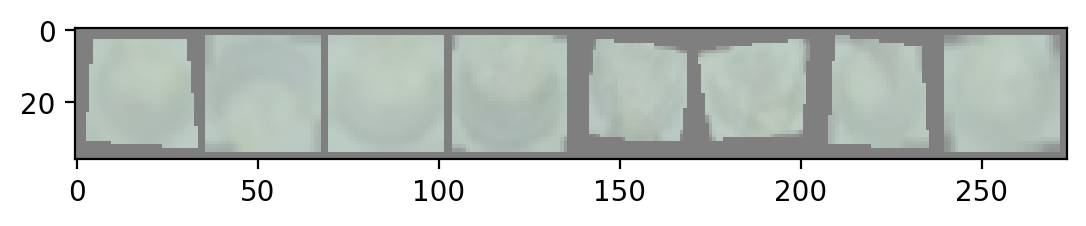

In [10]:
plot_sample(demo_loader_neproliv)

Images:


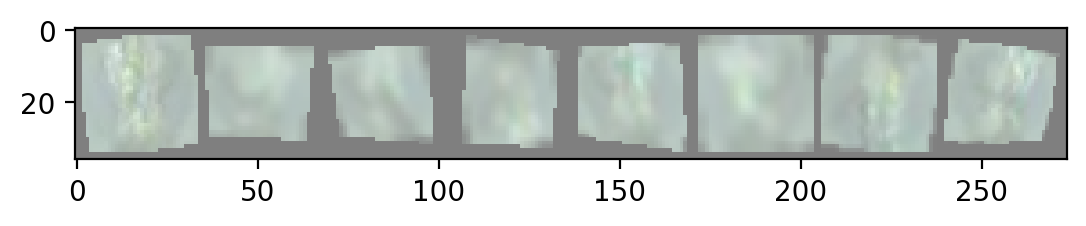

In [11]:
plot_sample(demo_loader_proliv)

In [12]:
model = ConvAutoencoder()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

num_epochs = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    for data in train_loader:
        inputs = data
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs = data
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            val_loss += criterion(outputs, inputs).item()

    # Average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    train_losses.append(loss.item())

    # Print training and validation losses for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

    # Save the model with the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

Epoch [1/20], Training Loss: 0.0036, Validation Loss: 0.0012
Epoch [2/20], Training Loss: 0.0020, Validation Loss: 0.0007
Epoch [3/20], Training Loss: 0.0014, Validation Loss: 0.0005
Epoch [4/20], Training Loss: 0.0009, Validation Loss: 0.0004
Epoch [5/20], Training Loss: 0.0007, Validation Loss: 0.0004
Epoch [6/20], Training Loss: 0.0008, Validation Loss: 0.0003
Epoch [7/20], Training Loss: 0.0006, Validation Loss: 0.0003
Epoch [8/20], Training Loss: 0.0006, Validation Loss: 0.0003
Epoch [9/20], Training Loss: 0.0005, Validation Loss: 0.0002
Epoch [10/20], Training Loss: 0.0004, Validation Loss: 0.0002
Epoch [11/20], Training Loss: 0.0004, Validation Loss: 0.0002
Epoch [12/20], Training Loss: 0.0003, Validation Loss: 0.0002
Epoch [13/20], Training Loss: 0.0004, Validation Loss: 0.0002
Epoch [14/20], Training Loss: 0.0005, Validation Loss: 0.0002
Epoch [15/20], Training Loss: 0.0003, Validation Loss: 0.0002
Epoch [16/20], Training Loss: 0.0003, Validation Loss: 0.0002
Epoch [17/20], Tr

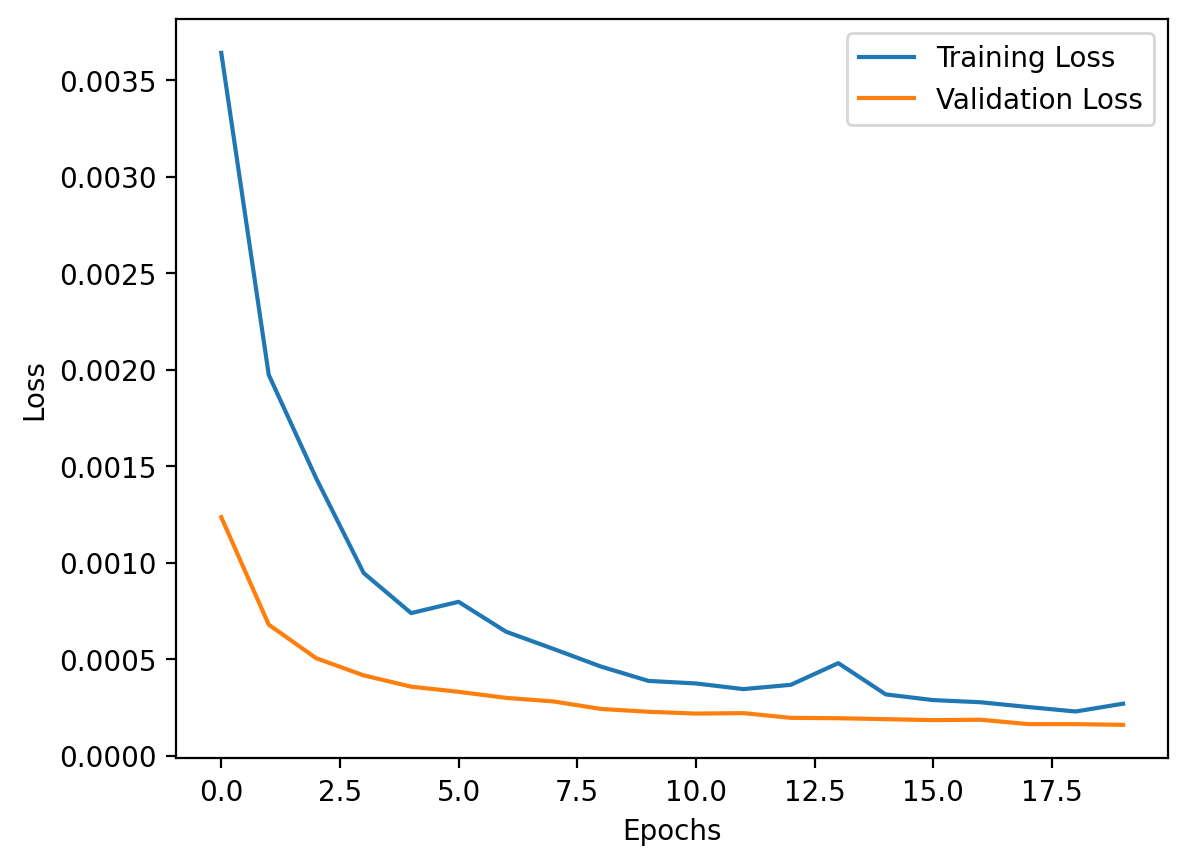

In [13]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

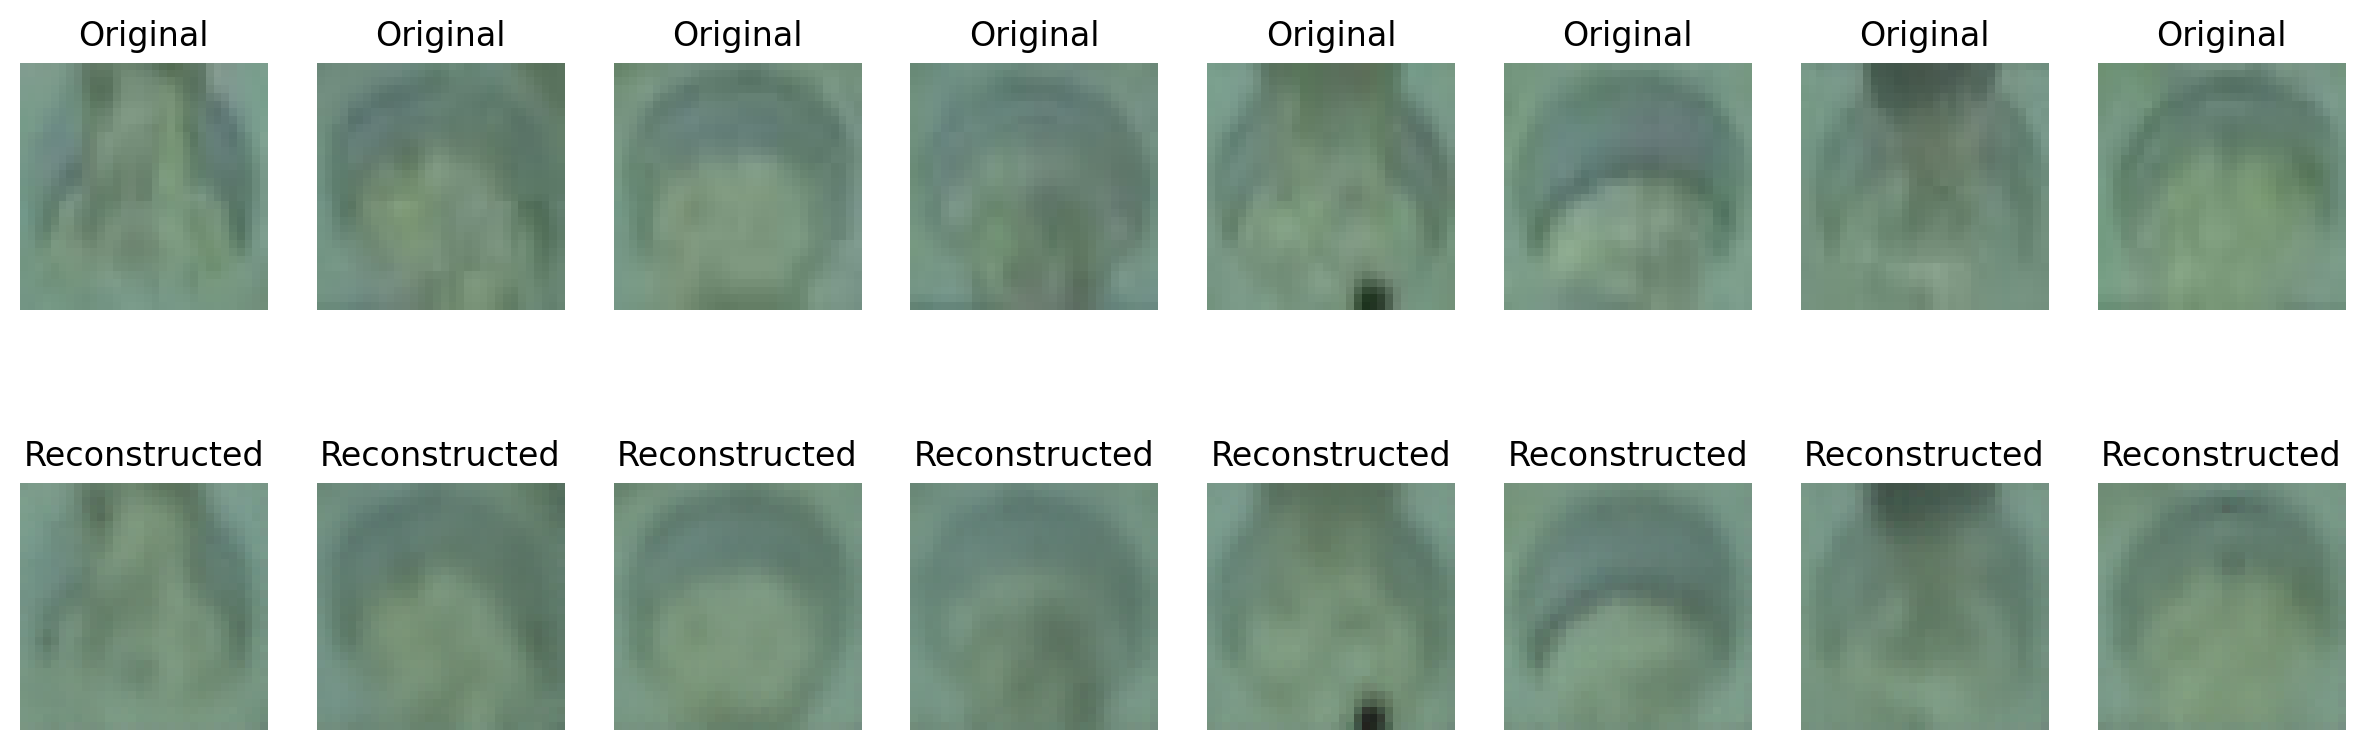

In [14]:
data_iter = iter(val_loader)
original_images = next(data_iter)
original_images = original_images.to(device)

# Reconstruct images using the autoencoder
reconstructed_images = model(original_images)

def display_images(original, reconstructed, num_images=8):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')

    plt.show()

# Display original and reconstructed images
display_images(original_images, reconstructed_images)

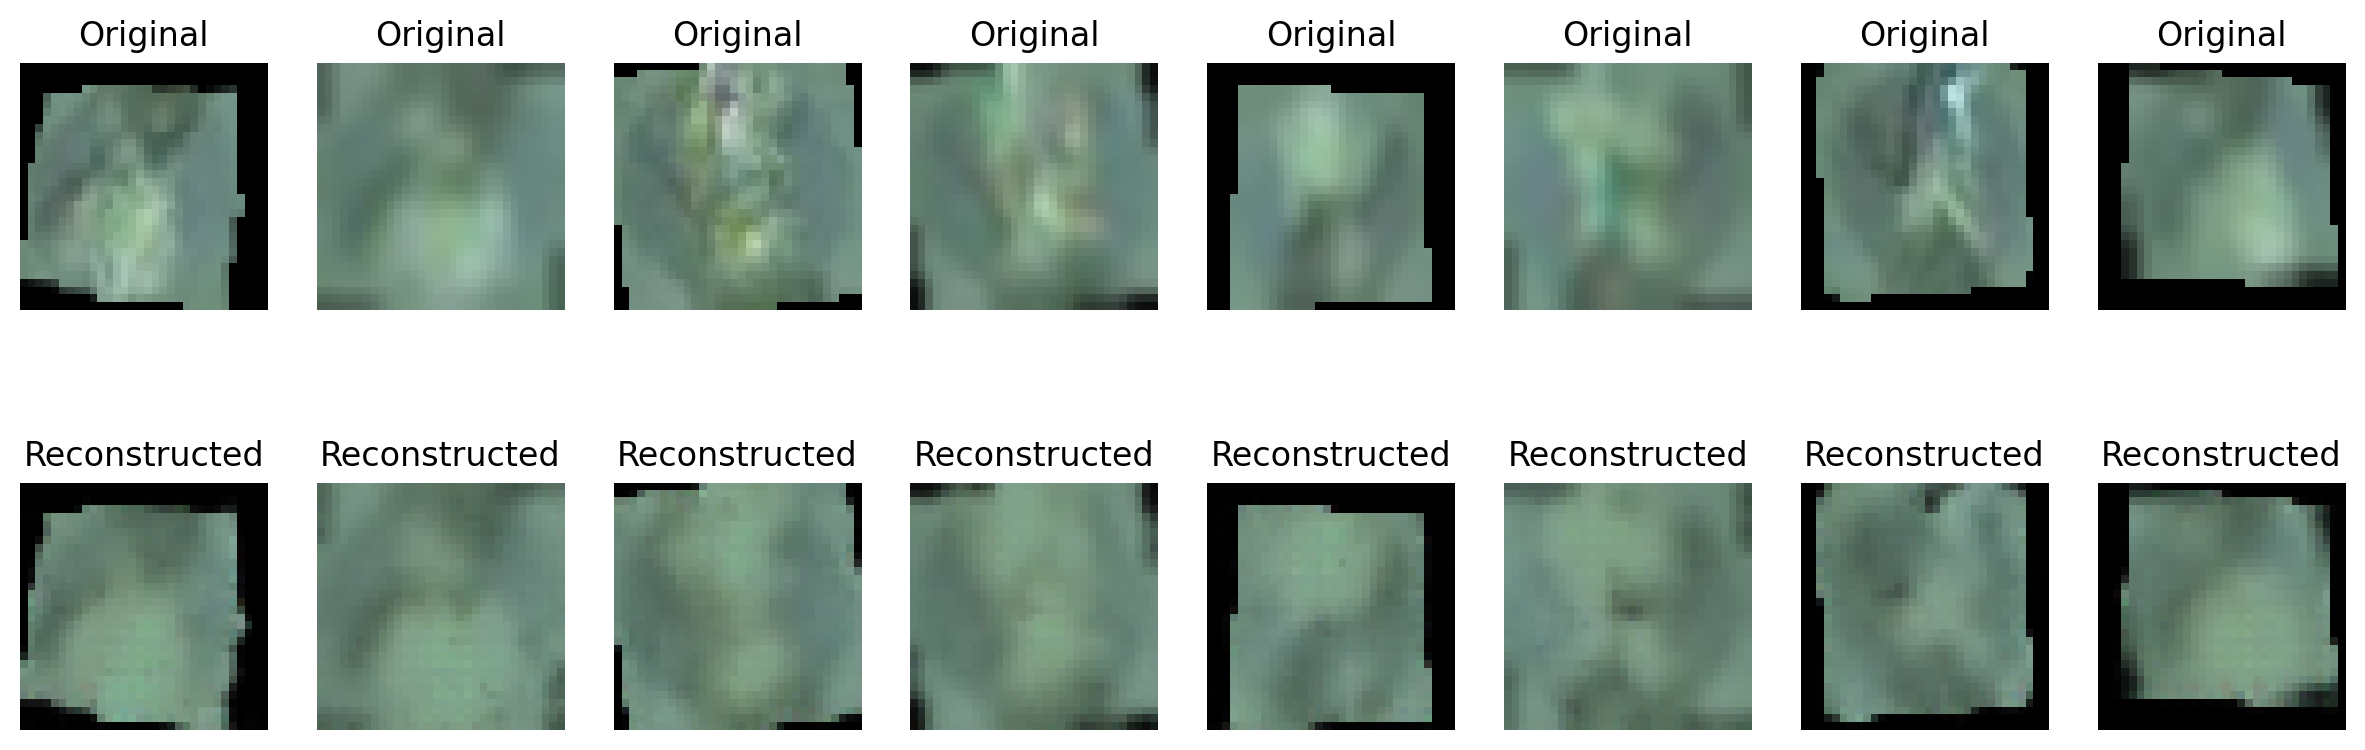

In [15]:
data_iter = iter(demo_loader_proliv)
original_images = next(data_iter)
original_images = original_images.to(device)

# Reconstruct images using the autoencoder
reconstructed_images = model(original_images)

# Display original and reconstructed images
display_images(original_images, reconstructed_images)

In [16]:
def compute_distances(model, dataloader):

  all_distances = []

  for batch in dataloader:
      original_images = batch
      original_images = original_images.to(device)

      # Reconstruct images using the autoencoder
      reconstructed_images = model(original_images)

      original_images = original_images.cpu().numpy()
      reconstructed_images = reconstructed_images.cpu().detach().numpy()

      for i in range(original_images.shape[0]):
          mse = mean_squared_error(original_images[i], reconstructed_images[i])
          all_distances.append(mse)

  return all_distances

In [17]:
proliv_images = glob(osp.join("/content/dataset/proliv", "*.jpg"))
proliv_dataset = ProlivDataset(proliv_images, test_transforms)
proliv_loader = DataLoader(proliv_dataset, batch_size=8, shuffle=False)

In [18]:
proliv_distances = compute_distances(model, proliv_loader)
neproliv_distances = compute_distances(model, val_loader)

<Axes: ylabel='Density'>

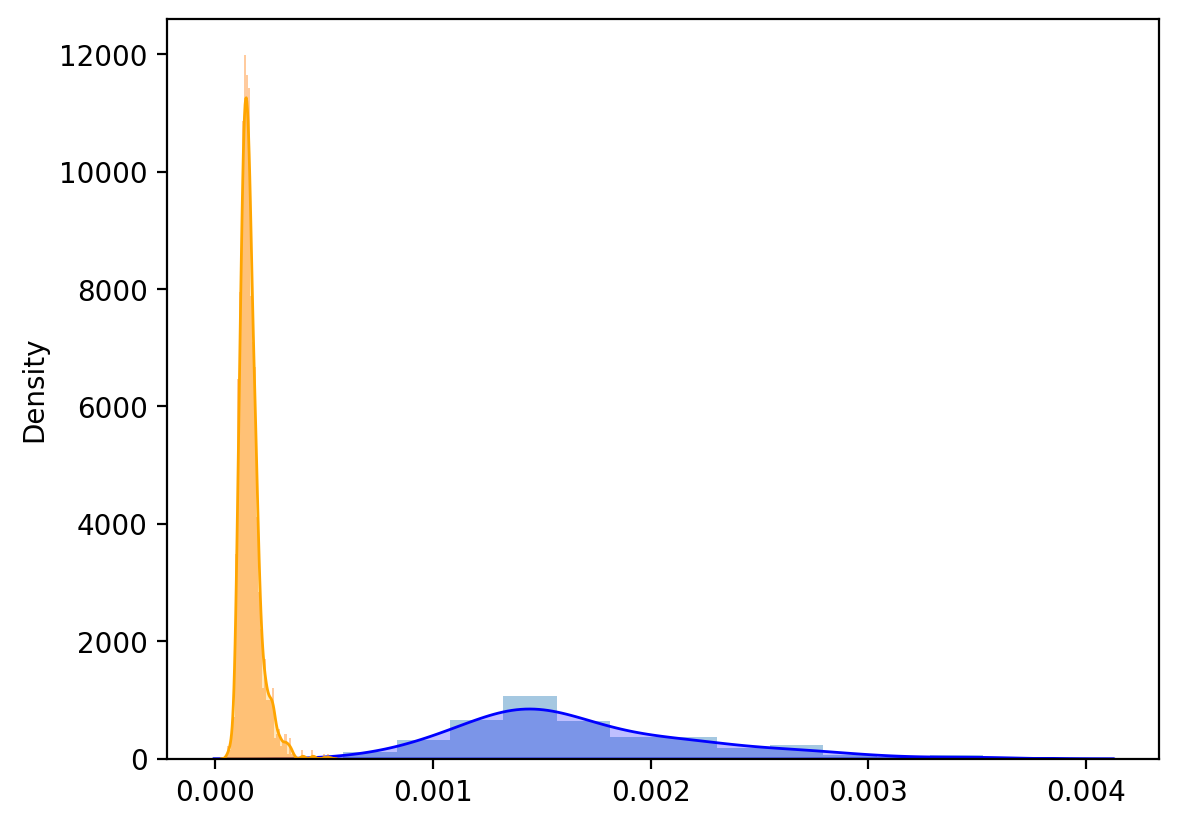

In [19]:
sns.distplot(proliv_distances, hist=True, kde_kws={"shade": True, "color": "blue"})
sns.distplot(neproliv_distances, hist=True, kde_kws={"shade": True, "color": "orange"})

In [20]:
class TestDataset(Dataset):
    def __init__(self, images_dir, ann_file, transforms):
        self.images_dir = images_dir
        self.ann = pd.read_csv(ann_file, header=None, sep=" ")
        self.transforms = transforms

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        image_name = self.ann.iloc[idx][0]
        label = self.ann.iloc[idx][1]

        image_path = osp.join(self.images_dir, image_name)
        image = Image.open(image_path)
        image = self.transforms(image)
        return image, label

In [21]:
test_dataset = TestDataset("/content/dataset/test/imgs",
                           "/content/dataset/test/test_annotation.txt",
                           test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
test_distances = []
gt = []

for images, labels in test_loader:

    original_images = images.to(device)
    reconstructed_images = model(original_images)

    original_images = original_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    for i in range(original_images.shape[0]):
        mse = mean_squared_error(original_images[i], reconstructed_images[i])
        test_distances.append(mse)
        gt.append(int(labels[i]))

In [23]:
thresh = 0.0004
pred = [1 if dist > thresh else 0 for dist in test_distances]

In [24]:
tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()

In [25]:
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

In [26]:
tpr, tnr

(0.9362015503875969, 0.9265620736698499)